# 3D Flex: Custom Mesh Rigidity

```{note}
[Read the tutorial](https://guide.cryosparc.com/processing-data/tutorials-and-case-studies/tutorial-3d-flexible-refinement) to learn more about 3D Flexible Refinement.
```

This example covers the following:

* How to read a 3DFlex Mesh from a 3DFlex Mesh Prep Job
* How to modify the rigidity weights of the mesh
* How to save this updated mesh back to CryoSPARC

Also described is the expected format in which mesh objects are represented to allow creating custom meshes and saving them it in the correct format within CryoSPARC.

In [1]:
import numpy as n

from cryosparc.tools import CryoSPARC

cs = CryoSPARC(host="cryoem5", base_port=40000)
assert cs.test_connection()

Connection succeeded to CryoSPARC command_core at http://cryoem5:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem5:40003


In [2]:
project = cs.find_project("P251")
job = project.find_job("J23")

##  Load the mesh_data from an existing 3DFlex Mesh Prep job

The mesh data in CryoSPARC is stored as a python pickle file containing several numpy arrays defining the mesh.

In [3]:
mesh_dset = job.load_output("flex_mesh", ["mesh"])
mesh_path = mesh_dset["mesh/path"][0]

In [4]:
import pickle

with project.download(mesh_path) as mesh_file:
    mesh_data = pickle.loads(mesh_file.read())

mesh_data.keys()

dict_keys(['mask', 'mask_soft', 'map_r', 'map_r_masked', 'N', 'psize_A', 'tm_points', 'tm_cells', 'tm_tetraidx_map', 'tm_rweights', 'segmask', 'segmask_exp', 'segfuses', 'tm_segmask', 'version'])

`mesh_data` has the following keys:

* `mask` : a hard binary mask that defines the protein region (i.e. a solvent mask)
* `mask_soft` : a soft mask that is within mask
* `map_r` : the input consensus density
* `map_r_masked` : the input consensus density, masked by mask_soft
* `N` : the box size
* `psize_A` : the pixel size
* `tm_points` : an array of (num_vertices x 3) point locations defining the mesh nodes
* `tm_cells` : an array of (num_cells x 4) indices of point defining the tetra elements
* `tm_tetraidx_map` : an (N x N x N) map, each voxel has the index of the tetra element to which it belongs. -1 in solvent regions
* `tm_rweights` : an array (num_cells) values that define the relative rigidity weights of each tetra element
* `segmask` : the segmentation mask that was used to define this mesh
* `segmask_exp` : an expanded segmentation mask that partitions the solvent mask
* `tm_segmask` : an array (num_cells) of indices that labels each tetra element with which segment it comes from
* `version` : a version number of this file

To define a custom mesh, provide a `mesh_data` pickle file with at least the following keys:

* `mask`
* `mask_soft`
* `N`
* `psize_A`
* `tm_points`
* `tm_cells`
* `tm_tetraidx_map`
* `tm_rweights`
* `version` = 1

## Customize the rigidity weights

In this example, we will customize the rigidity weights of the mesh. The new rigidity weights will be based on the distance of each tetra cell from the origin, just as an example. This weighting is unlikely to be useful in practice but shows how you can customize the weights based on any other information you wish to use.

In [5]:
N = mesh_data["N"]
tm_rweights = mesh_data["tm_rweights"]

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt


def plot_slice(data):
    plt.imshow(data[:, :, N // 2], origin="lower", interpolation="nearest")
    plt.colorbar()

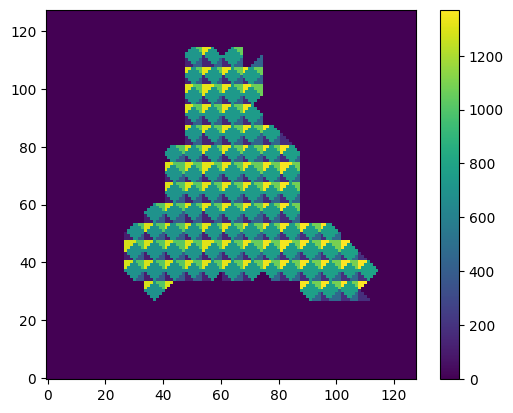

In [7]:
plot_slice(mesh_data["tm_tetraidx_map"])

In [8]:
def get_map_from_tm_data(tm_data, bg=0):
    tm_tim = mesh_data["tm_tetraidx_map"]
    res = tm_data[tm_tim]
    res[tm_tim < 0] = bg
    return res

In [9]:
map_rweights = get_map_from_tm_data(mesh_data["tm_rweights"])

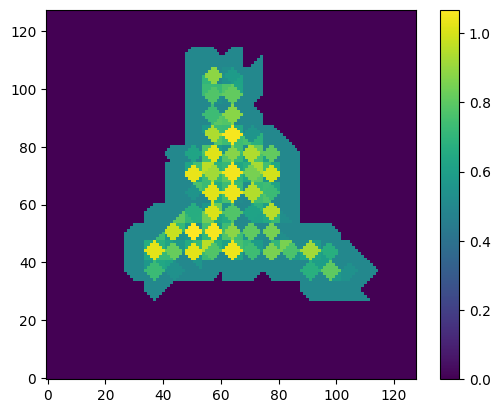

In [10]:
plot_slice(map_rweights)

In [11]:
tm_points = mesh_data["tm_points"]
tm_cells = mesh_data["tm_cells"]

Compute the distance of each tetra cell from the center of the box and use this as rigidity weights (just as an example).

In [12]:
tm_dist = n.linalg.norm(tm_points[tm_cells].mean(axis=-2), axis=-1)
tm_rweights_new = tm_dist / tm_dist.max()
map_rweights_new = get_map_from_tm_data(tm_rweights_new)

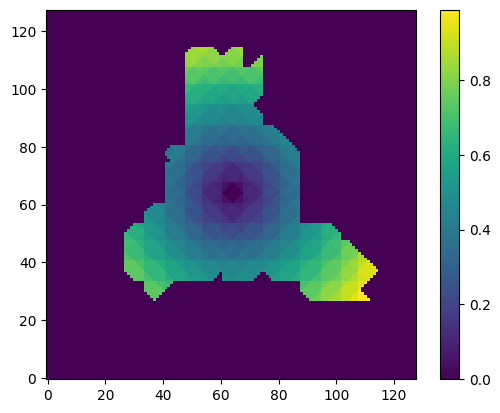

In [13]:
plot_slice(map_rweights_new)

### Saving the result

Use the same mesh_data object, replacing the `tm_rweights` with the new values. Upload this file to CryoSPARC and then save the result as a job linked to the original mesh generation job for bookkeeping.

In [14]:
mesh_data["tm_rweights"] = tm_rweights_new
mesh_stem = mesh_path.rsplit(".", 1)[0]
mesh_path_new = mesh_stem + "_new.pkl"
project.upload(mesh_path_new, pickle.dumps(mesh_data))

In [15]:
mesh_dset[0]["mesh/path"] = mesh_path_new
cs.save_external_result(
    project_uid="P251",
    workspace_uid="W4",
    dataset=mesh_dset,
    type="flex_mesh",
    name="mesh",
    slots=["mesh"],
    passthrough=("J23", "flex_mesh"),
    title="Custom mesh",
)

'J24'